# Диплом 2024

### Содержание:
- [Установка необходимых пакетов, если они не установлены](#inst_)
- [Импорт библиотек](#libr_)
- [Загрузка датасетов](#load_data_)
  - [Описание данных](#description)
- [Разведочный анализ даных (EDA)](#eda_)
  - [Посмотрим типы данных](#dtypes_)
  - [Посмотрим пропуски данных](#pass_)
  - [Посмотри статистику по датафрейму](#statistics_)
  - [Визуализируем данные](#visual_)
    - [Выделим численные признаки от даты](#num_and_char_)
    - [Создадим словарь признаков и пояснения](#translate_)
    - [Визуализируем распределение числовых признаков](#num_visual)
    - [Визуализируем распределение строковых признаков](#char_visual)
- [Предобработка признаков](#predobrabotka)
  - [Посмотрим какие признаки имеют выбросы](#vibros)
  - [Признак 'HouseYear'](#house_year)
  - [Признак 'Rooms'](#rooms)
  - [Признак 'KitchenSquare'](#kitchen_square)
  - [Признаки 'Square' и 'LifeSquare'](#square_life_square)
  - [Признаки 'HouseFloor' и 'Floor'](#floor_house_floor)
  - [Признак 'Healthcare_1'](#healthcare_1)
  - [Изменим тип признаков](#type_f)
  - [Ещё раз посмотрим скорректированные данные](#cor_data)
- [Создание класса подготовки данных](#create_class)
- [Построение новых признаков](#new_feature)
  - [DistrictSize, IsDistrictLarge (размеры районов)](#district_size)
  - [MedPriceDistrict (медиана цены квартиры в зависимости от района и количества комнат)](#med_price_district)
  - [MedPriceByFloorYear (средняя цена квартиры в зависимости от этажа и года постройки дома)](#med_price_by_floor_year)
- [Создание класса новых признаков](#create_class_2)
- [Создание модели](#create_model)
  - [Проверим модель без генерации новых фич](#model_1)
  - [Проверим модель с генерацией новых фич](#model_2)
- [Прогнозирование на тестовом датасете](#prognoz)
- [Вывод](#vivod)

### Установка пакетов если они не установлены <a class='anchor' id='inst_'>

In [1]:
# Для кождого проекта я использую новое окружение, 
# думаю это помогает избежать ошибок связанных с версиями пакетов
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install scikit-learn
# !pip install openpyxl

### Импортируем библиотеки <a class='anchor' id='libr_'>

In [2]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# Следующая магическая команда Jupyter Notebook нужна для того, чтобы графики
# отображались прямо в ноутбуке, а не в отдельном окне
%matplotlib inline

# Настройка более четкого отображения графиков
%config InlineBackend.figure_format = 'svg'

# Модуль для зазбиения выборки на тренировочнию и тестовую
from sklearn.model_selection import train_test_split

# Уберем warnings
import warnings
warnings.filterwarnings('ignore')

# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)

# Вычисление Z-score
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize

# Дата и время
from datetime import datetime

# Случайные числа
import random as rnd

# Алгоритм машинного обучения 'Метод случайного леса'
from sklearn.ensemble import RandomForestRegressor

# Кросс-валидация 
from sklearn.model_selection import cross_validate

# Разбиение
from sklearn.model_selection import KFold

# Метрика r2
from sklearn.metrics import r2_score

# Пути файловой системы
from pathlib import Path

# Регулярные выражения
import re

### Загружаем данные <a class='anchor' id='load_data_'>

Описание данных <a class='anchor' id='description'>
- **Id** - идентификационный номер квартиры;
- **DistrictId** - идентификационный номер района;
- **Rooms** - количество комнат;
- **Square** - площадь;
- **LifeSquare** - жилая площадь;
- **KitchenSquare** - площадь кухни;
- **Floor** - этаж;
- **HouseFloor** - количество этажей в доме;
- **HouseYear** - год постройки дома;
- **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели месности;
- **Social_1**, **Social_2**, **Social_3** - социальные показатели месности;
- **Healtcare_1**, **Heltcare_2** - показатели месности, связанные с охраной здоровья;
- **Shops_1**, **Shops_2** - показатели связанные с наличием магазинов, торговых центров;
- **Price** - цена квартиры.

In [3]:
# Расположение данных
PATH_DATASET = './Dataset'
# Минимальное количество строк в датасете
MIN_ROW = 6000


train_data = pd.DataFrame()

p = Path(Path.cwd() / PATH_DATASET)

for obj in p.iterdir():
    if obj.is_file():
        *_, name_file_all = str(obj).split('\\')
        name_file, type_file = name_file_all.split('.')
        if type_file == 'xlsx':
            df_temp = pd.read_excel(f'{PATH_DATASET}/{name_file_all}')
            # Переименуем стобцы
            df_temp.rename(columns={'Значение': f'{name_file}'}, inplace=True)
            # Нормализуем дату
            df_temp['Дата'] = df_temp['Дата'].dt.normalize()
            if train_data.shape[1]:
                if df_temp.shape[0] >= MIN_ROW:
                    print(f'Обработан {name_file_all} {df_temp.shape}')
                    train_data = pd.merge(train_data, df_temp, on='Дата', how='inner')
                    print(f'Размерность после merge {train_data.shape}')
                else:
                    print(f'Мало строк {name_file_all}')
            else:
                train_data = df_temp

Обработан eur_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 3)
Обработан gbp_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 4)
Обработан jpy_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 5)
Обработан s-p-500.xlsx (6178, 2)
Размерность после merge (5817, 6)
Обработан usd_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (5817, 7)
Мало строк бивалютная-корзина_rub.xlsx
Обработан золото-(банк-россии).xlsx (6034, 2)
Размерность после merge (4951, 8)
Обработан индекс-мосбиржи.xlsx (6130, 2)
Размерность после merge (4849, 9)
Мало строк китайский-юань---российский-рубль-cny_rub-(банк-россии).xlsx
Обработан нефть-brent.xlsx (6514, 2)
Размерность после merge (4849, 10)
Обработан палладий-(банк-россии).xlsx (6838, 2)
Размерность после merge (4849, 11)
Обработан платина-(банк-россии).xlsx (6912, 2)
Размерность после merge (4849, 12)
Обработан ртс.xlsx (6128, 2)
Размерность после merge (4842, 13)
Обработан серебро-(банк-россии).xlsx (6034

In [4]:
# Посмотрим, что загрузилось
train_data.head()

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии)
0,2024-07-09,98.46,95.66,112.84,0.55,5576.98,88.17,6743.87,3054.07,84.66,2908.39,2899.89,1093.26,86.68
1,2024-07-08,98.11,95.57,112.48,0.55,5572.85,88.13,6683.46,3132.58,85.64,2904.44,2867.60,1119.25,85.96
2,2024-07-05,97.77,94.98,112.46,0.55,5567.19,88.12,6690.03,3149.29,86.97,2954.96,2835.97,1125.66,85.36
3,2024-07-03,97.33,93.69,111.28,0.54,5537.02,87.99,6589.05,3203.07,86.63,2795.06,2786.57,1147.28,82.73
4,2024-07-02,96.98,93.96,110.36,0.54,5509.01,87.30,6542.06,3217.29,86.24,2728.08,2840.35,1151.82,82.43


In [5]:
# Посмотрим размер
train_data.shape

(4842, 14)

### Разведочный анализ даных (EDA) <a class='anchor' id='eda_'>

#### Посмотрим типы данных <a class='anchor' id='dtypes_'>

In [6]:
train_data.dtypes

Дата                      datetime64[ns]
chf_rub-(банк-россии)            float64
eur_rub-(банк-россии)            float64
gbp_rub-(банк-россии)            float64
jpy_rub-(банк-россии)            float64
s-p-500                          float64
usd_rub-(банк-россии)            float64
золото-(банк-россии)             float64
индекс-мосбиржи                  float64
нефть-brent                      float64
палладий-(банк-россии)           float64
платина-(банк-россии)            float64
ртс                              float64
серебро-(банк-россии)            float64
dtype: object

#### Посмотрим пропуски данных <a class='anchor' id='pass_'>

In [7]:
# Проверка того, в каких столбцах отсутствуют значения
print(train_data.isnull().sum(axis=0))

Дата                      0
chf_rub-(банк-россии)     0
eur_rub-(банк-россии)     0
gbp_rub-(банк-россии)     0
jpy_rub-(банк-россии)     0
s-p-500                   0
usd_rub-(банк-россии)     0
золото-(банк-россии)      0
индекс-мосбиржи           0
нефть-brent               0
палладий-(банк-россии)    0
платина-(банк-россии)     0
ртс                       0
серебро-(банк-россии)     0
dtype: int64


#### Посмотри статистику по датафрейму <a class='anchor' id='statistics_'>

In [8]:
train_data.describe()

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии)
count,4842,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00
mean,2014-01-02 13:36:21.412639232,48.55,56.61,69.02,0.43,2188.03,47.66,2131.57,1835.95,73.48,1656.40,1633.94,1248.14,29.36
min,2003-07-07 00:00:00,20.90,32.95,40.48,0.21,682.55,23.13,333.56,391.93,19.33,144.32,600.37,427.64,4.44
25%,2008-09-24 06:00:00,23.80,37.05,49.89,0.27,1256.26,29.06,714.63,1372.19,54.17,279.26,1188.66,991.46,12.92
50%,2013-12-28 12:00:00,37.15,45.97,54.48,0.39,1804.92,34.35,1668.49,1666.57,70.95,795.39,1648.30,1209.70,30.17
75%,2019-04-01 18:00:00,66.10,73.42,86.01,0.58,2850.82,65.24,2807.79,2306.90,91.78,2782.88,1930.70,1488.71,36.00
max,2024-07-09 00:00:00,115.22,113.26,136.04,0.85,5576.98,103.16,7231.12,4287.52,146.08,8507.40,3396.33,2487.92,92.42
std,NaN,24.83,21.01,22.59,0.16,1174.85,21.14,1585.96,840.20,25.37,1728.92,593.47,401.21,18.67


### Визуализируем данные <a class='anchor' id='visual_'>

#### Выделим численные признаки от даты <a class='anchor' id='num_and_char_'>

In [9]:
# Создадим список численных признаков
num_cols = [column for column in train_data if not column=='Дата']
# Признак даты
date_cols = 'Дата'
num_cols

['chf_rub-(банк-россии)',
 'eur_rub-(банк-россии)',
 'gbp_rub-(банк-россии)',
 'jpy_rub-(банк-россии)',
 's-p-500',
 'usd_rub-(банк-россии)',
 'золото-(банк-россии)',
 'индекс-мосбиржи',
 'нефть-brent',
 'палладий-(банк-россии)',
 'платина-(банк-россии)',
 'ртс',
 'серебро-(банк-россии)']

#### Создадим словарь признаков и пояснения <a class='anchor' id='translate_'>

In [10]:
# Словарь признаков и их пояснения
explanations_col = {
    'chf_rub-(банк-россии)': 'Швейцарский франк / Российский рубль',
    'eur_rub-(банк-россии)': 'Евро / Российский рубль',
    'gbp_rub-(банк-россии)': 'Британский фунт стерлингов / Российский рубль',
    'jpy_rub-(банк-россии)': 'Японская иена / Российский рубль',
    's-p-500': 'Индекс S&P 500',
    'usd_rub-(банк-россии)': 'Швейцарский франк / Российский рубль',
    'золото-(банк-россии)': '',
    'индекс-мосбиржи': '',
    'нефть-brent': '',
    'палладий-(банк-россии)': '',
    'платина-(банк-россии)': '',
    'ртс': 'Индекс РТС',
    'серебро-(банк-россии)': '',
}

#### Визуализируем распределение числовых признаков <a class='anchor' id='num_visual'>

In [11]:
def visualization_numerical_characteristics(X=train_data, explanations_col=explanations_col, dop_text=''):
    '''
    Визуализация цифровых признаков (так сделал, чтобы код в одном месте находился).

    :param X: датасет, который будем визуализировать,
    :param explanations_col: словарь признаков и их пояснения,
    :param dop_text: добавляется дополнительный текст к заголовку.
    '''
    plt.figure(figsize=[11, 13])

    # Общий заголовок для всех графиков
    plt.suptitle('Распределение числовых признаков '  + dop_text, 
                  y=1.005, 
                  fontsize=19, 
                  fontweight='bold')

    for i, col in enumerate(num_cols):
        plt.subplot(6, 3, i+1)
        # Заголовок для графика
        explanations = ''
        if not explanations_col[col] is '':
            explanations = f'\n({explanations_col[col]})'
        plt.title(f'\n{col}{explanations}', fontsize=10)
        # Задаём размер шривта и угол поворота текста для осей X и Y
        plt.xticks(fontsize=8, rotation=0)
        plt.yticks(fontsize=8, rotation=0)
        # Делаем размер шрифта по Y=5, не уберая название оси
        plt.ylabel('', fontsize=5)
        # Отрисовываем гистограмму
        plt.hist(X[col])

    # Автоматически уместить все элементы на полотне    
    plt.tight_layout()

    # Вывести графики на экран
    plt.show()

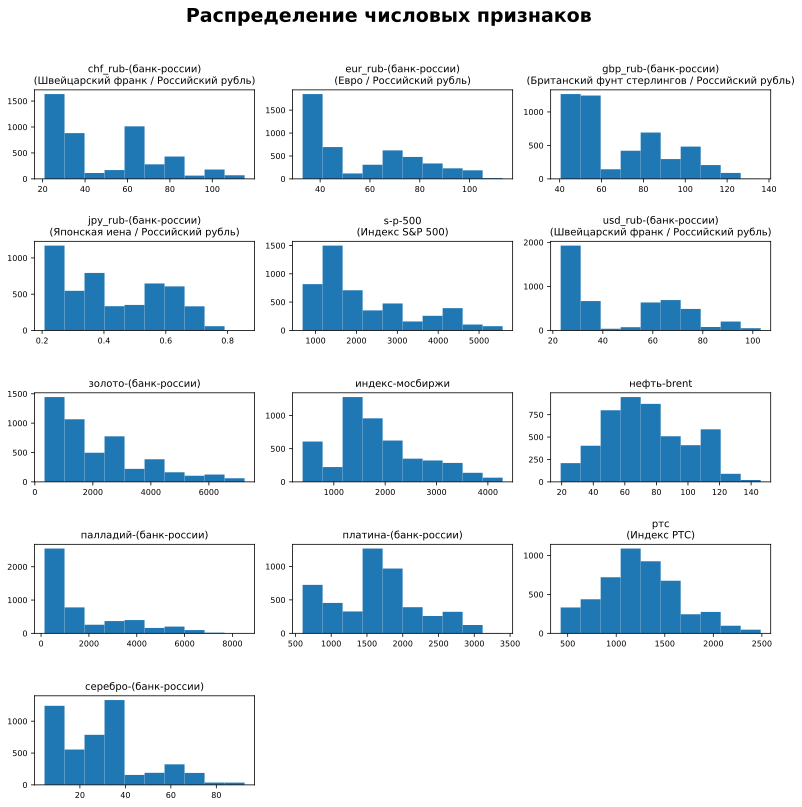

In [12]:
visualization_numerical_characteristics()

### Предобработка признаков <a class='anchor' id='predobrabotka'>

#### Посмотрим какие признаки имеют выбросы <a class='anchor' id='vibros'>

In [13]:
def emission_test(ds, col_test, threshold_val=3, explanations_col=explanations_col):
    '''
    Функция проводит тестирование столбцов на выбросы методом Z-score.
    
    :param ds: исследуемый датасет,
    :param col_test: список колонок,
    :param threshold_val: пороговое значение Z-score,
    :param explanations_col: словарь признаков и их пояснения,
    :return: текстовый отчет и список выбросов.
    '''
    result = ''
    NUM = 2  # количество цифр после запятой
    outliers_list = [] # лист выбросов
    for col in col_test:
        # Вычисление Z-score
        z = np.abs(stats.zscore(ds[col]))
        # Установка порогового значения Z-score
        threshold = 3
        # Выявление выбросов на основе Z-score
        outliers = ds[col][z > threshold]
        
        if len(outliers) > 0:
            outliers_list.append(outliers)
            
            result += f'В столбце {col} ({explanations_col[col]}),\n{len(outliers)} выбросов. Mean: {round(ds[col].mean(), NUM)}, ' \
            f'Min: {round(ds[col].min(), NUM)}, Max: {round(ds[col].max(), NUM)}, ' \
            f'Moda: {round(ds[col].mode()[0], NUM)}, Median: {round(ds[col].median(), NUM)} \n\n'
    
    return f'Выбросов нет. ' if result == '' else result, outliers_list

In [14]:
def viev_outliers(outliers_list, col_name):
    '''
    Функция выводит строки датафрейма, в которых есть выбросы.
    
    :param outliers_list: список выбросов,
    :param col_name: название признака (фичи),
    :return: индексы выбросов.
    '''
    for item in outliers:
        if item.name == col_name:
            return item.index 

In [15]:
# Выведем признаки которые имеют выбросы
text_outliers, outliers = emission_test(ds=train_data, col_test=num_cols)

In [16]:
# Выведем текстовый отчёт по выбросам
print(text_outliers)

В столбце золото-(банк-россии) (),
23 выбросов. Mean: 2131.57, Min: 333.56, Max: 7231.12, Moda: 5993.16, Median: 1668.5 

В столбце палладий-(банк-россии) (),
22 выбросов. Mean: 1656.4, Min: 144.32, Max: 8507.4, Moda: 3275.71, Median: 795.39 

В столбце ртс (Индекс РТС),
6 выбросов. Mean: 1248.14, Min: 427.64, Max: 2487.92, Moda: 982.94, Median: 1209.7 

В столбце серебро-(банк-россии) (),
23 выбросов. Mean: 29.36, Min: 4.44, Max: 92.42, Moda: 32.11, Median: 30.17 




### Test

In [17]:
# # Модуль для работы с временными рядами
# from sklearn.model_selection import TimeSeriesSplit

In [18]:
def choice_quarter(month):
    '''
    Функция определения квартала.

    :param month: номер месяца 1-12,
    :return: номер квартала 1-4, или -1, если ошибка.
    '''
    if month <= 3:
        return 1
    elif 4 <= month <= 6:
        return 2
    elif 7 <= month <= 9:    
        return 3
    elif 10 <= month <= 12:    
        return 4
    else:
        return -1

# Создадим дополнительные признаки (год, месяц, день, день недели (Пн-Вс), номер недели, квартал, полугодие)
train_data['Year'] = train_data['Дата'].dt.year
train_data['Month'] = train_data['Дата'].dt.month
train_data['Weekday'] = train_data['Дата'].dt.weekday
train_data['Day'] = train_data['Дата'].dt.day
train_data['Week'] = train_data['Дата'].dt.isocalendar().week
# train_data['Halfyear'] = train_data['Дата'].apply(lambda x: 1 if x.month < 7 else 2)
train_data['Quarter'] = train_data['Month'].apply(lambda x: choice_quarter(x))
# Установим столбец даты в качестве индекса
# train_data = train_data.set_index('Дата')

train_data.head()

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии),Year,Month,Weekday,Day,Week,Quarter
0,2024-07-09,98.46,95.66,112.84,0.55,5576.98,88.17,6743.87,3054.07,84.66,2908.39,2899.89,1093.26,86.68,2024,7,1,9,28,3
1,2024-07-08,98.11,95.57,112.48,0.55,5572.85,88.13,6683.46,3132.58,85.64,2904.44,2867.60,1119.25,85.96,2024,7,0,8,28,3
2,2024-07-05,97.77,94.98,112.46,0.55,5567.19,88.12,6690.03,3149.29,86.97,2954.96,2835.97,1125.66,85.36,2024,7,4,5,27,3
3,2024-07-03,97.33,93.69,111.28,0.54,5537.02,87.99,6589.05,3203.07,86.63,2795.06,2786.57,1147.28,82.73,2024,7,2,3,27,3
4,2024-07-02,96.98,93.96,110.36,0.54,5509.01,87.30,6542.06,3217.29,86.24,2728.08,2840.35,1151.82,82.43,2024,7,1,2,27,3


In [19]:
# item_mean_year = train_data.groupby(['Year']).agg({'usd_rub-(банк-россии)':'mean'}).rename(columns={'usd_rub-(банк-россии)':'usd-rub-year'})
# item_mean_year

In [20]:
# item_mean_year = item_mean_year['usd-rub-year'].shift(1)
# item_mean_year

In [21]:
# train_data.dtypes

In [22]:
def not_correct_year(df=train_data, min_month=12, min_day=200):
    '''
    Функция выдает список не корректных годов, где min_month и min_day меньше заданного.

    :param  df: исследуемый датафрейм,
    :param  min_month: минимальное количество месяцев в году,
    :param  min_day: минимальное количество дней в году,
    :return: возвращает список не корректных годов и текстовый отчёт.
    '''

    not_corr_year = []
    txt_report = ''
    
    for year in df['Year'].unique():
        month_quantity = len(df[df['Year']==year]['Month'].unique())
        day_quantity = len(df[df['Year']==year]['Weekday'])
        if (month_quantity < min_month) or (day_quantity < min_day):
            not_corr_year.append(int(year))
        txt_report += f'Год: {year}, кол. месяцев: {month_quantity}, кол. дней: {day_quantity}\n'

    return not_corr_year, txt_report

In [23]:
# Протестируем датасет и запишем список не корректных годов и отчёт
not_correct_year_list, report = not_correct_year()
print(report)

Год: 2024, кол. месяцев: 7, кол. дней: 124
Год: 2023, кол. месяцев: 12, кол. дней: 237
Год: 2022, кол. месяцев: 12, кол. дней: 214
Год: 2021, кол. месяцев: 12, кол. дней: 233
Год: 2020, кол. месяцев: 12, кол. дней: 225
Год: 2019, кол. месяцев: 12, кол. дней: 232
Год: 2018, кол. месяцев: 12, кол. дней: 227
Год: 2017, кол. месяцев: 12, кол. дней: 232
Год: 2016, кол. месяцев: 12, кол. дней: 232
Год: 2015, кол. месяцев: 12, кол. дней: 231
Год: 2014, кол. месяцев: 12, кол. дней: 233
Год: 2013, кол. месяцев: 12, кол. дней: 232
Год: 2012, кол. месяцев: 12, кол. дней: 230
Год: 2011, кол. месяцев: 12, кол. дней: 232
Год: 2010, кол. месяцев: 12, кол. дней: 224
Год: 2009, кол. месяцев: 12, кол. дней: 230
Год: 2008, кол. месяцев: 12, кол. дней: 226
Год: 2007, кол. месяцев: 12, кол. дней: 227
Год: 2006, кол. месяцев: 12, кол. дней: 232
Год: 2005, кол. месяцев: 12, кол. дней: 231
Год: 2004, кол. месяцев: 12, кол. дней: 235
Год: 2003, кол. месяцев: 6, кол. дней: 123



In [24]:
# # Создадим новый датафрейм в котором не будет не корректных годов
# X = train_data.loc[~train_data['Year'].isin(not_correct_year_list)]
# # Посмотрим статистику
# (X['Year'].min(), X['Year'].max())

In [25]:
# X.shape

In [26]:
# # Создадим список валют
# currency_list = [column for column in train_data if '_' in column]
# currency_list

In [27]:
# def create_target(df, currency_list):
#     '''
#     Функция создает таргеты (целевая переменная), среднее значение (год, пол года, квартал, неделя)

#     :param  df: исследуемый датафрейм,
#     :param  currency_list: список валют,
#     :return: возвращает датафрейм с таргетами, название колонок которые добавили.
#     '''

#     train_test_dict = {}
    
    
#     # Вычислим среднее значение за год 
#     for item in currency_list:
#         # Оставляем в тексте только латиницу и нижний слеш
#         item_text = re.sub(r'[^a-z_]', '', item)
#         new_name_columns = f'{item_text}-mean'.replace('_', '-')

#         # Вычисление среднего курса за год
#         name_columns = f'{new_name_columns}-year'
#         item_mean_year = df.groupby(['Year']).agg({item:'mean'}).rename(columns={item:name_columns})
#         item_mean_year[name_columns] = item_mean_year[name_columns]
#         # x = x.merge(item_mean_year, on=['Year'], how='left')

#         # Вычисление среднего куса за месяц
#         name_columns = f'{new_name_columns}-month'
#         item_mean_month = df.groupby(['Year', 'Month']).agg({item:'mean'}).rename(columns={item:name_columns})
#         item_mean_month[name_columns] = item_mean_month[name_columns]
#         result = df.merge(item_mean_month, on=['Year', 'Month'], how='left')

#         # Удалили пустые строки
#         result.dropna(subset=[name_columns], inplace=True)
#         # Установим столбец даты в качестве индекса
#         result.set_index('Дата', inplace=True)
#         # Создадим X и y датасеты
#         # y = temp[name_columns]
#         # X = temp.drop(columns=name_columns, axis=1)

#         # result.drop(columns=currency_list, axis=1, inplace=True)
#         train_test_dict[name_columns] = result
        

    
#     return  train_test_dict

In [28]:
# train_test_date = create_target(train_data, currency_list)

In [29]:
# for key, value in train_test_date.items():
#     print(key)

In [30]:
# # Разбили на train и test
# data = train_test_date['chf-rub-mean-month'].copy()
# train_query = '(Year < 2023) | ((2023 <= Year <2024 ) & (Month == 4))'
# test_query = '(2023 <= Year <2024 ) & (Month == 5)'
# y_train = data.query(train_query)['chf-rub-mean-month']
# y_test = data.query(test_query)['chf-rub-mean-month']
# data.drop(columns=['chf-rub-mean-month'], axis=1, inplace=True)
# data.drop(columns=currency_list, axis=1, inplace=True)
# X_train = data.query(train_query)
# X_test = data.query(test_query)
# X_test 

Потом надо перенести (начало)

In [31]:
# # Создадим модель с количеством деревьев в лесу 2000, с максимальной глубиной залегания дерева 21 (эти параметры подобрал с помощью GridSearchCV)
# rf_model = RandomForestRegressor(n_estimators=2000, max_depth=21, random_state=42, criterion='squared_error')

In [32]:
# %%time
# # Обучим модель
# rf_model.fit(X_train, y_train)

In [33]:
# # Выполним предикт
# y_pred = rf_model.predict(X_test)
# # Посмотрим эффективность модели по метрике r2
# print(f'Эффективность модели по метрике r2: {r2_score(y_test, y_pred)}')

In [34]:
# train_test_date['chf-rub-mean-month'].resample("M").mean().tail(20)

In [35]:
# train_test_date['chf-rub-mean-month']['2023-05-02':].resample("M").mean().sort_values(by='Дата').head(5)

In [36]:
# train_test_date['chf-rub-mean-month'].resample("M").mean().tail(5)

In [126]:
# Метрика
def mape(y_test, y_pred):
    '''
    Функция вычисляет ошибку в процентах от средних значений предсказанных и тестовых.

    :param  y_test: тестовые значения таргета,
    :param  y_pred: предсказанные значения таргета,
    :return: возвращает ошибку предсказания в процентах.
    '''
    return abs((y_test.mean() - y_pred.mean()) / y_pred.mean()) * 100

Потом надо перенести (конец)

In [157]:
# Кросвалидация на временном ряду
def cross_validation_on_time_series(data, start_year, number_cross_validations, type_cross_validations, target_name):
    '''
    Функция-генератор, кросс валидирует курсы валют на временном ряду.

    :param  data: датафрем с данными,
    :param  start_year: год с которого будем кросс валидироваться,
    :param  number_cross_validations: количество кросс валидаций,
    :param  type_cross_validations: тип кросс валидаций (Year, Quarter, Month, Week),
    :param  target_name: имя таргета (целевой переменной),
    :return: возвращает X_train, y_train, X_test, y_test, summary, time_point_test.
    '''
    # Удаляем все не латинские знаки, делаем первую букву заглавную, остальные обычные
    resample_param = re.sub(r'[^a-zA-z]', '', type_cross_validations).capitalize()
    resample_code = ''
    # Создадим список валют
    currency_list = [column for column in data if '_' in column]
    # Тригер первого включения
    triger = False
    
    # Выставляем параметр для сводной таблицы
    if resample_param == 'Year':
        resample_code = 'YE'
    elif resample_param == 'Quarter':
        resample_code = 'BQE'
    elif resample_param == 'Month':
        resample_code = 'ME'
    elif resample_param == 'Week':
        resample_code = 'W'    
    else:
        raise ValueError(f'Ошибка параметра "type_cross_validations={type_cross_validations}". Корректно: Year, Quarter, Month, Week') 

    # Делаем датафрем независимым
    df = data.copy(deep=True)
    # Сделаем резервную копию даты
    df['Дата-copy'] = df['Дата']
    # Установим столбец даты в качестве индекса
    df = df.set_index('Дата-copy')
    # Выберем данные после стартового года
    df = df.query(f'(Year >= {start_year})')

    # Создадим X_train и y_train
    # Делаем датафрем независимым
    X_train = data.copy(deep=True)
    X_train = X_train.query(f'(Year < {start_year})')
    # Установим столбец даты в качестве индекса
    X_train = X_train.set_index('Дата')
    # Создадим таргет
    y_train = X_train[target_name] 
    # Удалим все ненужные столбцы из X_train
    X_train.drop(columns=currency_list, axis=1, inplace=True)
    
    # Проверка
    n_row = df.resample(resample_code).count().shape[0]
    if n_row < number_cross_validations:
        raise ValueError(f'Столько данных с параметрами "start_year={start_year}", не найдём ((')
    
    # Если всё ок разбиваем на train и test
    for row in range(number_cross_validations):
        # Добавляем данные из предыдущего цикла, если он не первый
        if triger:
            X_train = pd.concat([X_train, X_test])
            y_train = pd.concat([y_train, y_test])
        else:
            triger = True
        # Читаем строчку сводной таблицы
        pivot_table_row = pd.DataFrame(df.resample(resample_code).mean().iloc[row]).T[['Year', resample_param]]
        # Соединяем таблицу и строку сводной таблицы
        result = df.merge(pivot_table_row, on=['Year', resample_param], how='right')
        result = result.set_index('Дата')
        # Запишем таргет в отдельную переменную
        y_test = result[target_name]
        # Удалим все таргеты из датасета
        result.drop(columns=currency_list, axis=1, inplace=True)
        X_test = result
        # Инфа по данным
        summary = f'Train({X_train.index.min().strftime('%d.%m.%Y')}-{X_train.index.max().strftime('%d.%m.%Y')}, X.shape{X_train.shape}, y.shape{y_train.shape}), ' \
                  f'Test({X_test.index.min().strftime('%d.%m.%Y')}-{X_test.index.max().strftime('%d.%m.%Y')}, X.shape{X_test.shape}, y.shape{y_test.shape})'
        # Запишем переменные времени, для графика
        time_point_test = X_test.index.max()
        
        
        yield X_train, y_train, X_test, y_test, summary, time_point_test


In [184]:
%%time
# Создадим модель с количеством деревьев в лесу 2000, с максимальной глубиной залегания дерева 21 (эти параметры подобрал с помощью GridSearchCV)
rf_model = RandomForestRegressor(n_estimators=2000, max_depth=21, random_state=42, criterion='squared_error')

# Статистика кросс валидации
cv_info = pd.DataFrame({'date':[], 'error':[]})

for  X_train, y_train, X_test, y_test, summary, time_point_test in cross_validation_on_time_series(train_data, 2020, 3, 'Quarter', 'usd_rub-(банк-россии)'):
    # Обучим модель
    rf_model.fit(X_train, y_train)
    # # Выполним предикт
    y_pred = rf_model.predict(X_test)
    # Посмотрим эффективность модели 
    cv_error = mape(y_test, y_pred)
    # Запишем статистику кросс валидации
    cv_info.loc[len(cv_info)]  = {'date':time_point_test, 'error':cv_error}

    print(f'{summary}, Ошибка: {round(cv_error, 2)} %')

Train(07.07.2003-30.12.2019, X.shape(3809, 14), y.shape(3809,)), Test(10.01.2020-30.03.2020, X.shape(51, 14), y.shape(51,)), Ошибка: 0.98 %
Train(07.07.2003-30.03.2020, X.shape(3860, 14), y.shape(3860,)), Test(07.04.2020-30.06.2020, X.shape(50, 14), y.shape(50,)), Ошибка: 0.5 %
Train(07.07.2003-30.06.2020, X.shape(3910, 14), y.shape(3910,)), Test(02.07.2020-30.09.2020, X.shape(63, 14), y.shape(63,)), Ошибка: 8.67 %
CPU times: total: 1min 55s
Wall time: 2min 43s


In [185]:
cv_info

,date,error
0,2020-03-30,0.98
1,2020-06-30,0.50
2,2020-09-30,8.67


In [45]:
# test = train_test_date['chf-rub-mean-month']
# cross_validation_on_time_series(test, 2024, 2, 'month')

In [46]:
# gb = test.query('(Year >= 2024) & (Month == 2)').groupby(['Month', 'Year'], as_index=False).agg({'chf_rub-(банк-россии)':'median'}).rename(columns={'chf_rub-(банк-россии)':'Med'})
# # Добавляем этот признак в датафрейм
# # x = x.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
# gb

In [47]:
# # Добавляем этот признак в датафрейм
# tt = test.merge(gb, on=['Year', 'Month'], how='right')
# tt

In [48]:
# test.query(f'(Year >= 2024)').resample('ME').count().sort_values(by='Дата', ascending=False)

In [49]:
# tt = pd.DataFrame(test.query(f'(Year >= 2024)').resample('ME').mean().sort_values(by='Дата', ascending=True).iloc[1]).T
# tt = tt[['Year','Month']]
# tt

In [50]:
# test.query(f'(Year >= 2024)').resample('ME').count().sort_values(by='Дата', ascending=True)

In [51]:
# tt = pd.DataFrame(test.query(f'(Year >= 2024)').resample('ME').mean().iloc[3]).T[['Year','Month']]

# tt

In [52]:
# tt_2 = test.merge(tt, on=['Year', 'Month'], how='right').sort_values(by=['Year', 'Month', 'Day'], ascending=True)
# tt_2

In [53]:
# tscv = TimeSeriesSplit(n_splits=241, test_size=19)
# for i, (train_index, test_index) in enumerate(tscv.split(X)):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

In [54]:
# tscv = TimeSeriesSplit(n_splits=241, test_size=19)
# for i, (train_index, test_index) in enumerate(tscv.split(X)):
#     print(f"Fold {i}:")
#     rf_model_new_features.fit(X.iloc[train_index], y.iloc[train_index])
#     y_pred = rf_model_new_features.predict(X.iloc[test_index])
#     # Посмотрим эффективность модели по метрике r2
#     print(f'Эффективность модели по метрике r2: {r2_score(y.iloc[test_index], y_pred)}')


In [55]:
# # Создадим модель с количеством деревьев в лесу 2000, с максимальной глубиной залегания дерева 21 (эти параметры подобрал с помощью GridSearchCV)
# rf_model= RandomForestRegressor(n_estimators=2000, max_depth=21, random_state=42, criterion='squared_error')

In [56]:
# X.iloc[0]

In [57]:
# y.iloc[0]

In [58]:
# tscv = TimeSeriesSplit(n_splits=240)
# for train, test in tscv.split():

In [59]:
g = x.to_numpy()
g.shape

NameError: name 'x' is not defined

In [ ]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])

tscv = TimeSeriesSplit()
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

In [ ]:
train_data['Дата'].min(), train_data['Дата'].max()

In [ ]:
train_data['Дата'].max() - train_data['Дата'].min() 

In [ ]:
tscv = TimeSeriesSplit(n_splits=15)
for i, (train_index, test_index) in enumerate(tscv.split(x)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

In [ ]:
for item in test:
    print(item)

### Прогнозирование на тестовом датасете <a class='anchor' id='prognoz'>

### Вывод: <a class='anchor' id='vivod'>
.
